# Setup

## Import modules

In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt

2024-03-24 07:40:01.783074: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 07:40:01.840293: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 07:40:02.169528: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 07:40:02.169689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 07:40:02.237438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Load the data: the FordA dataset

In [3]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]  # label
    x = data[:, 1:] # data
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

# reshape
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# count the classes
num_classes = len(np.unique(y_train))

# shaffle for training
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

# standarize
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Visualize the data

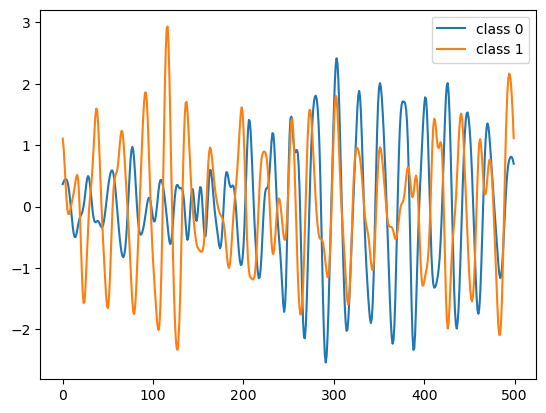

In [4]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

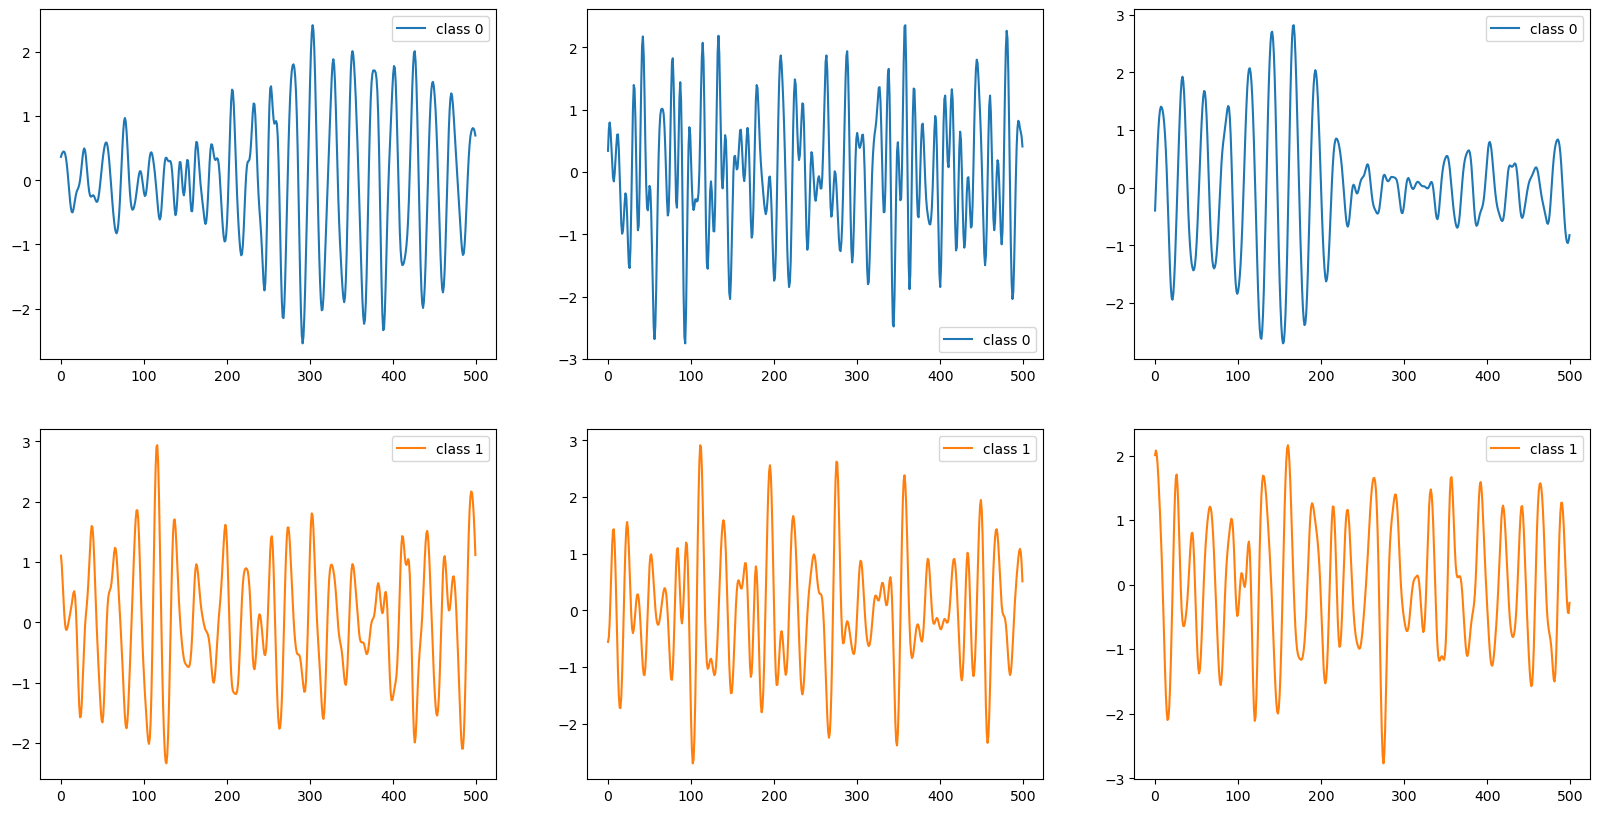

In [5]:
num_plots_per_label = 3

classes = np.unique(np.concatenate((y_train, y_test), axis=0))
color = {0: 'tab:blue', 1: 'tab:orange'}

plt.figure(figsize=(20,10))
for c in classes:
    c_x_train = x_train[y_train == c]
    for n in range(num_plots_per_label):
        plt.subplot(2, 3, (n+1)+c*3)
        plt.plot(c_x_train[n], label="class " + str(c), color=color[c])
        plt.legend(loc="best")
plt.show()
plt.close()

# 1D-CNN Model

## Build a model

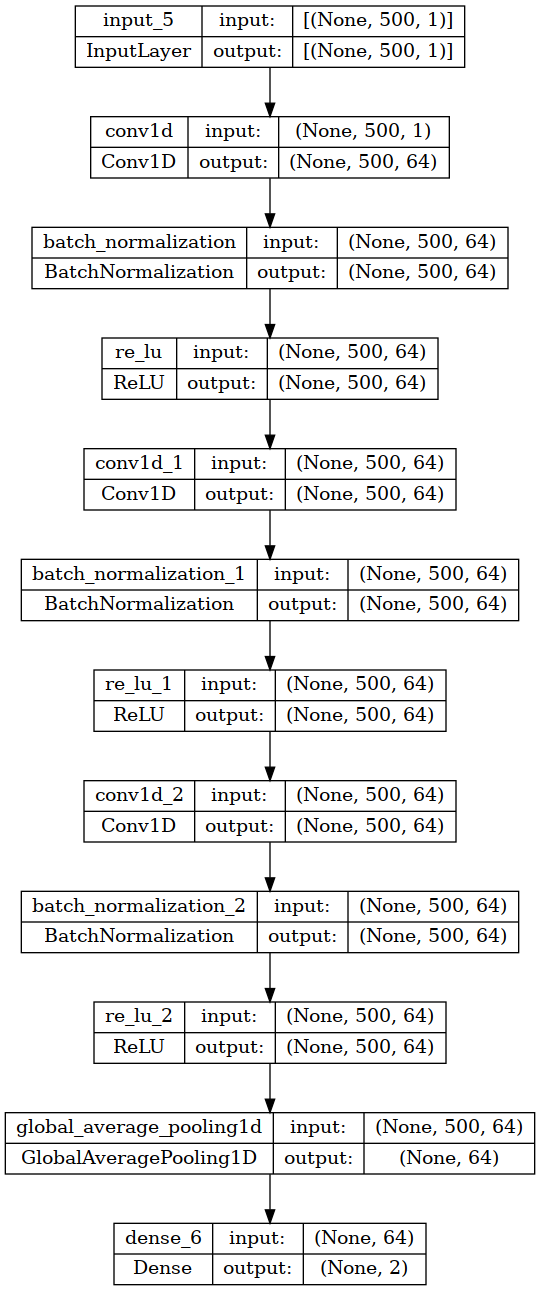

In [157]:
def make_1d_cnn_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_1d_cnn_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [158]:
print(model.count_params())

25858


## Train the model

In [6]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "./model/best_1d_cnn_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 [==============================] - 8s 63ms/step - loss: 0.5608 - sparse_categorical_accuracy: 0.7063 - val_loss: 0.8095 - val_sparse_categorical_accuracy: 0.4827 - lr: 0.0010
Epoch 2/500
90/90 [==============================] - 7s 73ms/step - loss: 0.4503 - sparse_categorical_accuracy: 0.7868 - val_loss: 0.7590 - val_sparse_categorical_accuracy: 0.4827 - lr: 0.0010
Epoch 3/500
90/90 [==============================] - 5s 61ms/step - loss: 0.4417 - sparse_categorical_accuracy: 0.7917 - val_loss: 0.7313 - val_sparse_categorical_accuracy: 0.5173 - lr: 0.0010
Epoch 4/500
90/90 [==============================] - 7s 73ms/step - loss: 0.4373 - sparse_categorical_accuracy: 0.7778 - val_loss: 0.7385 - val_sparse_categorical_accuracy: 0.4951 - lr: 0.0010
Epoch 5/500
90/90 [==============================] - 5s 56ms/step - loss: 0.4147 - sparse_categorical_accuracy: 0.7937 - val_loss: 0.6580 - val_sparse_categorical_accuracy: 0.6436 - lr: 0.0010
Epoch 6/500
90/90 [================

## Evaluate model on test data

In [7]:
model = keras.models.load_model("./model/best_1d_cnn_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 1s 17ms/step - loss: 0.0955 - sparse_categorical_accuracy: 0.9667
Test accuracy 0.9666666388511658
Test loss 0.095504529774189


## Plot the model's traing and valudation loss

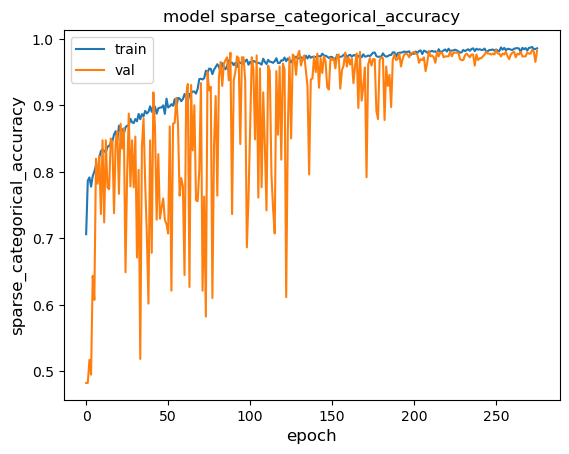

In [8]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

# GRU Model

## Build a model

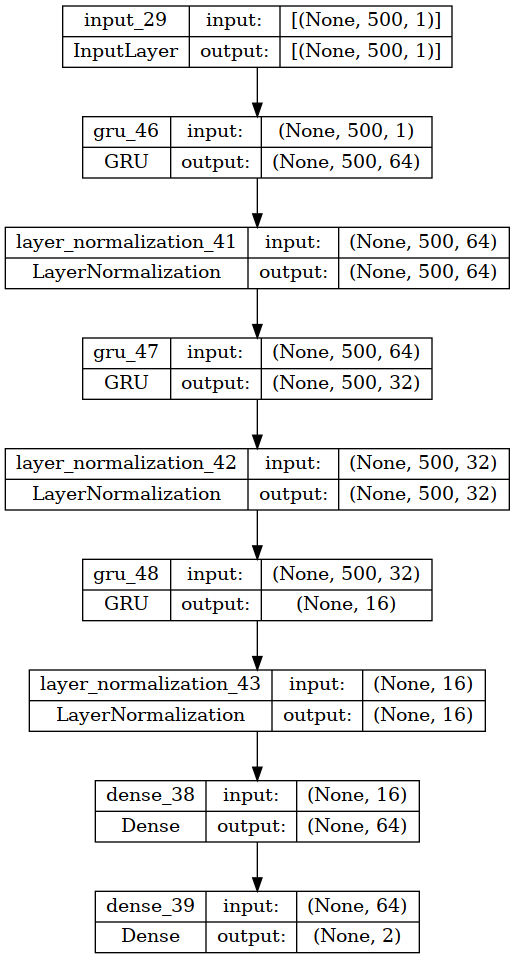

In [202]:
def make_gru_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    gru1 = keras.layers.GRU(64, return_sequences=True)(input_layer)
    gru1 = keras.layers.LayerNormalization()(gru1)
    
    gru2 = keras.layers.GRU(32, return_sequences=True)(gru1)
    gru2 = keras.layers.LayerNormalization()(gru2)

    gru3 = keras.layers.GRU(16)(gru2)
    gru3 = keras.layers.LayerNormalization()(gru3)

    relu = keras.layers.Dense(64, activation='relu')(gru3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(relu)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_gru_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [203]:
print(model.count_params())

26114


## Train the model

In [204]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "./models/best_gru_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 [==============================] - 55s 577ms/step - loss: 0.7047 - sparse_categorical_accuracy: 0.4944 - val_loss: 0.6958 - val_sparse_categorical_accuracy: 0.5090 - lr: 0.0010
Epoch 2/500
90/90 [==============================] - 46s 515ms/step - loss: 0.6951 - sparse_categorical_accuracy: 0.5233 - val_loss: 0.6986 - val_sparse_categorical_accuracy: 0.5104 - lr: 0.0010
Epoch 3/500
90/90 [==============================] - 47s 522ms/step - loss: 0.6903 - sparse_categorical_accuracy: 0.5326 - val_loss: 0.7063 - val_sparse_categorical_accuracy: 0.5076 - lr: 0.0010
Epoch 4/500
90/90 [==============================] - 51s 571ms/step - loss: 0.6918 - sparse_categorical_accuracy: 0.5250 - val_loss: 0.6865 - val_sparse_categorical_accuracy: 0.5160 - lr: 0.0010
Epoch 5/500
90/90 [==============================] - 64s 714ms/step - loss: 0.6836 - sparse_categorical_accuracy: 0.5333 - val_loss: 0.6880 - val_sparse_categorical_accuracy: 0.5312 - lr: 0.0010
Epoch 6/500
90/90 [======

## Evaluate model on test data


In [205]:
model = keras.models.load_model("./models/best_gru_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 8s 156ms/step - loss: 0.1778 - sparse_categorical_accuracy: 0.9364
Test accuracy 0.9363636374473572
Test loss 0.17782416939735413


## Plot the model's traing and validation loss

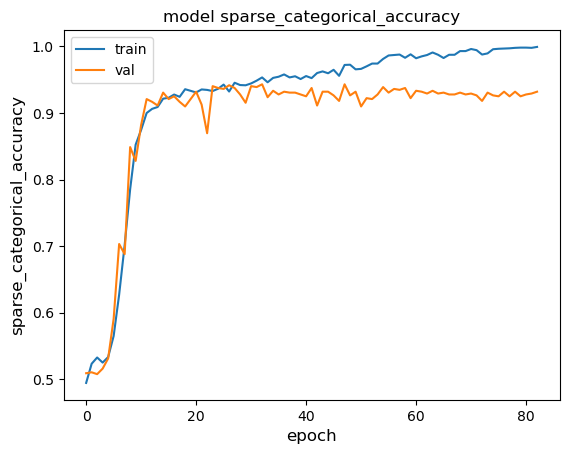

In [206]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

# LSTM Model

## Build a model

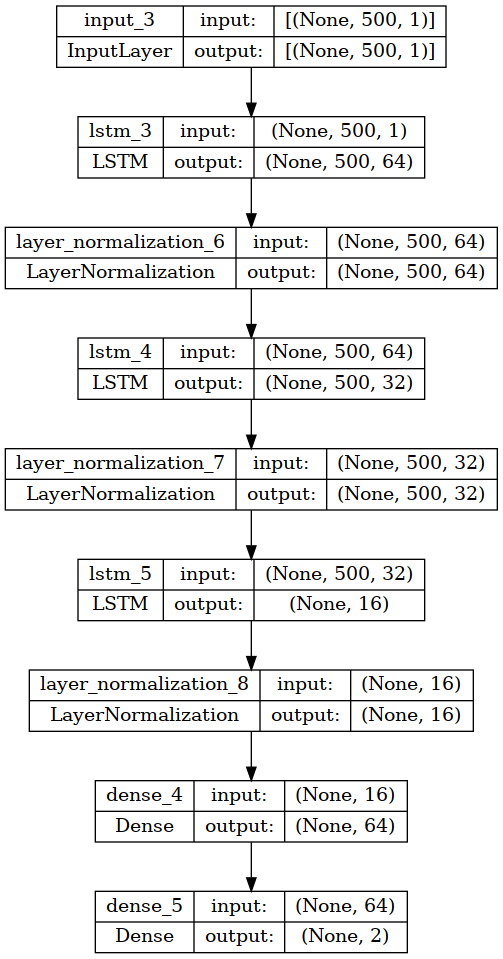

In [17]:
def make_lstm_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    lstm1 = keras.layers.LSTM(64, return_sequences=True)(input_layer)
    lstm1 = keras.layers.LayerNormalization()(lstm1)

    lstm2 = keras.layers.LSTM(32, return_sequences=True)(lstm1)
    lstm2 = keras.layers.LayerNormalization()(lstm2)

    lstm3 = keras.layers.LSTM(16)(lstm2)
    lstm3 = keras.layers.LayerNormalization()(lstm3)

    relu = keras.layers.Dense(64, activation='relu')(lstm3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(relu)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_lstm_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [18]:
print(model.count_params())

33890


## Train the model

In [19]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "./models/best_lstm_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 [==============================] - 51s 516ms/step - loss: 0.7014 - sparse_categorical_accuracy: 0.5278 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.5007 - lr: 0.0010
Epoch 2/500
90/90 [==============================] - 49s 542ms/step - loss: 0.6958 - sparse_categorical_accuracy: 0.5236 - val_loss: 0.7010 - val_sparse_categorical_accuracy: 0.4979 - lr: 0.0010
Epoch 3/500
90/90 [==============================] - 46s 510ms/step - loss: 0.6928 - sparse_categorical_accuracy: 0.5201 - val_loss: 0.6969 - val_sparse_categorical_accuracy: 0.4965 - lr: 0.0010
Epoch 4/500
90/90 [==============================] - 47s 523ms/step - loss: 0.6887 - sparse_categorical_accuracy: 0.5451 - val_loss: 0.6921 - val_sparse_categorical_accuracy: 0.5035 - lr: 0.0010
Epoch 5/500
90/90 [==============================] - 51s 566ms/step - loss: 0.6879 - sparse_categorical_accuracy: 0.5309 - val_loss: 0.7045 - val_sparse_categorical_accuracy: 0.5090 - lr: 0.0010
Epoch 6/500
90/90 [======

## Evaluate model on test data

In [20]:
model = keras.models.load_model("./models/best_lstm_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 8s 131ms/step - loss: 0.1623 - sparse_categorical_accuracy: 0.9394
Test accuracy 0.939393937587738
Test loss 0.16233204305171967


## Plot the models's traing and validation loss

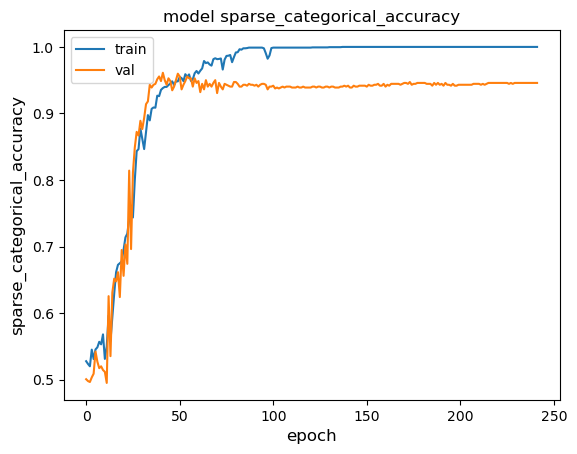

In [21]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

# Simple RNN Model

## Build a model

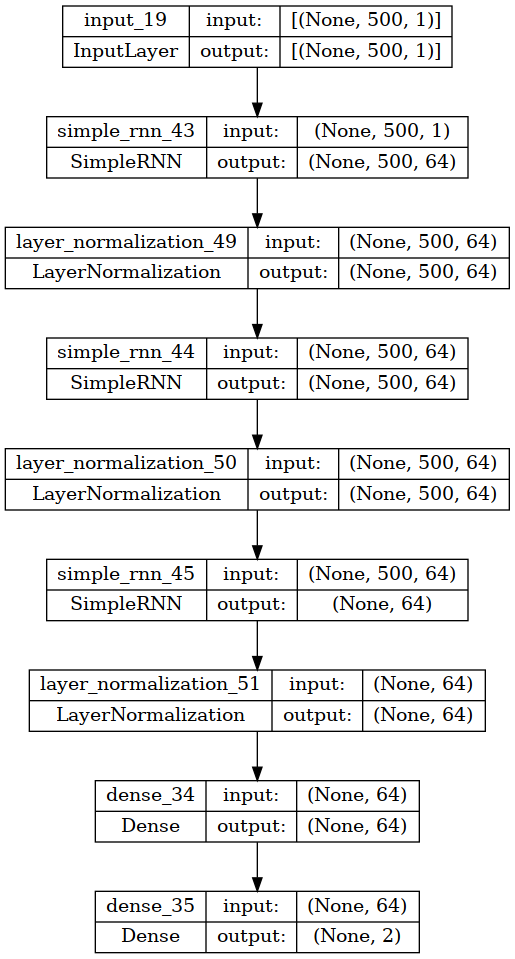

In [64]:
def make_rnn_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    rnn1 = keras.layers.SimpleRNN(64, return_sequences=True)(input_layer)
    rnn1 = keras.layers.LayerNormalization()(rnn1)

    rnn2 = keras.layers.SimpleRNN(64, return_sequences=True)(rnn1)
    rnn2 = keras.layers.LayerNormalization()(rnn2)

    rnn3 = keras.layers.SimpleRNN(64)(rnn2)
    rnn3 = keras.layers.LayerNormalization()(rnn3)

    relu = keras.layers.Dense(64, activation='relu')(rnn3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(relu)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_rnn_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [65]:
print(model.count_params())

25410


## Train the model

In [66]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "./models/best_rnn_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=150, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size
    
    
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500


90/90 [==============================] - 33s 336ms/step - loss: 0.6965 - sparse_categorical_accuracy: 0.5604 - val_loss: 0.6951 - val_sparse_categorical_accuracy: 0.5492 - lr: 0.0010
Epoch 2/500
90/90 [==============================] - 31s 346ms/step - loss: 0.6992 - sparse_categorical_accuracy: 0.5392 - val_loss: 0.7330 - val_sparse_categorical_accuracy: 0.5035 - lr: 0.0010
Epoch 3/500
90/90 [==============================] - 30s 337ms/step - loss: 0.7117 - sparse_categorical_accuracy: 0.4986 - val_loss: 0.6982 - val_sparse_categorical_accuracy: 0.5146 - lr: 0.0010
Epoch 4/500
90/90 [==============================] - 31s 345ms/step - loss: 0.7146 - sparse_categorical_accuracy: 0.4913 - val_loss: 0.7024 - val_sparse_categorical_accuracy: 0.4688 - lr: 0.0010
Epoch 5/500
90/90 [==============================] - 31s 346ms/step - loss: 0.7054 - sparse_categorical_accuracy: 0.5003 - val_loss: 0.7025 - val_sparse_categorical_accuracy: 0.5215 - lr: 0.0010
Epoch 6/500
90/90 [==================

## Evalutate model on test data

In [67]:
model = keras.models.load_model("./models/best_rnn_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 8s 85ms/step - loss: 0.5960 - sparse_categorical_accuracy: 0.6621
Test accuracy 0.6621212363243103
Test loss 0.5960062146186829


## Plot the model's traing and validation loss

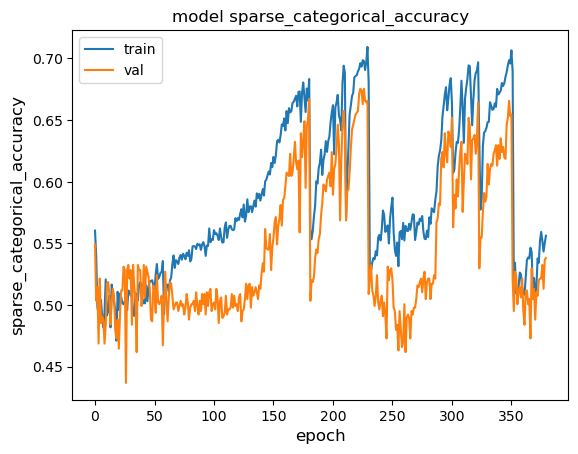

In [68]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

# Predict

## Import modules

In [37]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## Confusion Matrix

In [38]:
model = keras.models.load_model("./models/best_1d_cnn_model.keras")

predictions = np.argmax(model.predict(x_test), axis=1)

print(confusion_matrix(y_test, predictions))

42/42 [==============================] - 1s 12ms/step
[[655  26]
 [ 18 621]]


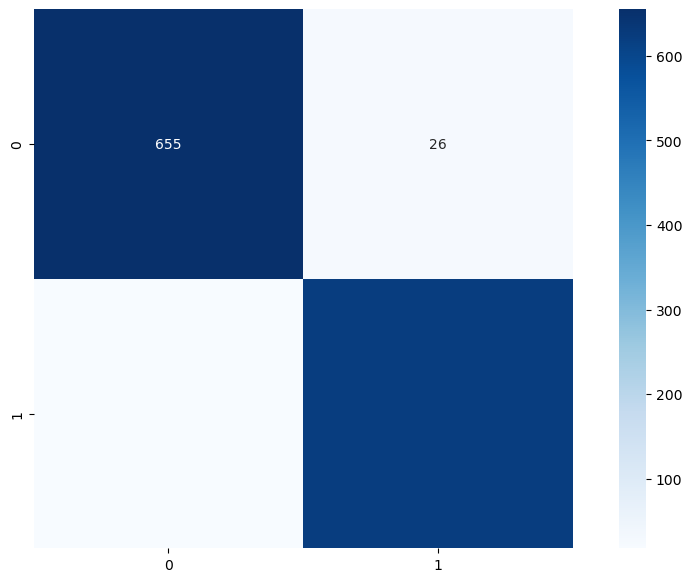

In [39]:
def show_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    
    plt.figure(figsize=(12,7))
    sn.heatmap(df_cmx, annot=True, fmt='g', square=True, cmap='Blues')
    plt.show()
    

show_cmx(y_test, predictions)

# Convert the model for TensorFlow Lite

In [7]:
import tensorflow as tf

model_name_list = ['1d_cnn', 'rnn', 'lstm', 'gru']

for model_name in model_name_list:
    # Load Keras model
    keras_model = tf.keras.models.load_model(f'./models/best_{model_name}_model.keras')

    # Create TensorFlow Lite Converter
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)

    # Convert
    try:
        tflite_model = converter.convert()
    except:
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
            tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
        ]
        tflite_model = converter.convert()

    # Save the converted model
    with open(f'./models/best_{model_name}_model.tflite', 'wb') as f:
        f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpnp8qlj6n/assets


INFO:tensorflow:Assets written to: /tmp/tmpnp8qlj6n/assets
2024-04-03 15:59:42.952809: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-03 15:59:42.952874: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-03 15:59:42.953041: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpnp8qlj6n
2024-04-03 15:59:42.956611: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-03 15:59:42.956654: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpnp8qlj6n
2024-04-03 15:59:42.967299: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-03 15:59:43.048231: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpnp8qlj6n
2024-04-03 15:59:43.075560: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjz3meck8/assets


INFO:tensorflow:Assets written to: /tmp/tmpjz3meck8/assets
2024-04-03 15:59:46.448070: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-03 15:59:46.448148: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-03 15:59:46.448366: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpjz3meck8
2024-04-03 15:59:46.453573: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-03 15:59:46.453638: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpjz3meck8
2024-04-03 15:59:46.477296: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-03 15:59:46.596253: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpjz3meck8
2024-04-03 15:59:46.705136: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvg0w3tgd/assets


INFO:tensorflow:Assets written to: /tmp/tmpvg0w3tgd/assets
2024-04-03 15:59:50.937267: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-03 15:59:50.937359: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-03 15:59:50.937704: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvg0w3tgd
2024-04-03 15:59:50.944425: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-03 15:59:50.944524: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpvg0w3tgd
2024-04-03 15:59:50.968376: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-03 15:59:51.110128: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpvg0w3tgd
2024-04-03 15:59:51.157198: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmph0qmzuo9/assets


INFO:tensorflow:Assets written to: /tmp/tmph0qmzuo9/assets
2024-04-03 16:00:01.660557: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-03 16:00:01.661161: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-03 16:00:01.661433: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmph0qmzuo9
2024-04-03 16:00:01.685818: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-03 16:00:01.685864: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmph0qmzuo9
2024-04-03 16:00:01.780340: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-03 16:00:02.026138: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmph0qmzuo9
2024-04-03 16:00:02.167017: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpebzfacsd/assets


INFO:tensorflow:Assets written to: /tmp/tmpebzfacsd/assets
2024-04-03 16:00:14.177652: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-03 16:00:14.177712: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-03 16:00:14.177977: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpebzfacsd
2024-04-03 16:00:14.194113: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-03 16:00:14.194152: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpebzfacsd
2024-04-03 16:00:14.267092: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-03 16:00:14.513139: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpebzfacsd
2024-04-03 16:00:14.678257: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpy6ano9tw/assets


INFO:tensorflow:Assets written to: /tmp/tmpy6ano9tw/assets
2024-04-03 16:00:24.007395: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-03 16:00:24.007462: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-03 16:00:24.007646: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpy6ano9tw
2024-04-03 16:00:24.019956: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-03 16:00:24.019997: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpy6ano9tw
2024-04-03 16:00:24.067691: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-03 16:00:24.227699: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpy6ano9tw
2024-04-03 16:00:24.334800: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp51xpo76y/assets


INFO:tensorflow:Assets written to: /tmp/tmp51xpo76y/assets
2024-04-03 16:00:32.884886: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-03 16:00:32.884986: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-03 16:00:32.885427: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp51xpo76y
2024-04-03 16:00:32.899653: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-03 16:00:32.899697: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp51xpo76y
2024-04-03 16:00:32.947638: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-03 16:00:33.096468: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp51xpo76y
2024-04-03 16:00:33.194430: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

In [41]:
import tensorflow as tf
from sklearn.metrics import accuracy_score


def predict_tflite(x_test_data):
    # Load the TFLite model
    interpreter = tf.lite.Interpreter("./models/best_1d_cnn_model.tflite")

    # Allocate tensors (required)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Predict
    input_shape = input_details[0]['shape']
    input_data = np.array(x_test_data, dtype='float32')  # convert dtype from float64 to float32
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index']).argmax()
    
    return output_data


predictions = []
for i_x_test in range(len(x_test)):
    output_data = predict_tflite(x_test[i_x_test:i_x_test+1,:,:])
    predictions.append(output_data)

accuracy_score(y_test, predictions)

0.9666666666666667